In [27]:
import json
import time
import re
import nltk
import gensim.downloader
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np



from glob import glob
from tqdm import tqdm

from gensim.models import KeyedVectors
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def json_to_dataframe(file_path):
    return pd.read_json(file_path, lines=True)

files = glob("data/*.jsonl")
dfs = [json_to_dataframe(file) for file in files]
df = pd.concat(dfs, ignore_index=True)

#  Preprocessing

In [3]:
# Creating the answers_df
human_df = pd.DataFrame({'questions': df['question'], 'answers': df['human_answers'], 'is_human': 1 })
gpt_df = pd.DataFrame({'questions': df['question'], 'answers': df['chatgpt_answers'], 'is_human': 0})
answers_df = pd.concat([human_df, gpt_df], axis=0, ignore_index=True)

# Cleaning
answers_df = answers_df.explode('answers', ignore_index=True)
answers_df = answers_df.dropna(subset=['answers'], ignore_index=True)
answers_df = answers_df[~answers_df['answers'].str.endswith('There was an error generating a response')]
answers_df = answers_df[~answers_df['answers'].str.endswith('Log out')]
deprecated_df = answers_df[answers_df['answers'].str.len() != 0]

# Importing other_df
csv = pd.read_csv("data/hack_train.csv")
csvFull = csv.rename(columns={'text': 'answers', "label" : "is_human"})
newly_df = csvFull.drop(columns="src")

display(deprecated_df.head())
newly_df.head()

,questions,answers,is_human
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",1
1,"Why is every book I hear about a "" NY Times # ...","If you 're hearing about it , it 's because it...",1
2,"Why is every book I hear about a "" NY Times # ...","One reason is lots of catagories . However , h...",1
3,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,1
4,"If salt is so bad for cars , why do we use it ...","In Minnesota and North Dakota , they tend to u...",1


,answers,is_human
0,Little disclaimer: this deals with US laws and...,1
1,"Read: Mentally Retarded Downs. See, we've got ...",1
2,"If any of you frequent rbadhistory, there is a...",1
3,"I believe in a flat tax system, where everyone...",1
4,"Edit: Ok guy's, my views have been changed on ...",1


In [4]:
X = newly_df['answers']
y = newly_df['is_human']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# Analyse du Dataset

In [15]:
def compare_len_dataset(df):
    humain = df[df["is_human"] == 1].copy()
    gpt = df[df["is_human"] == 0].copy()

    human_len_mean = round(humain.answers.apply(len).mean())
    gpt_len_mean = round(gpt['answers'].apply(len).mean())

    print("AI answer Len:", gpt_len_mean )
    print("Human answer len:", human_len_mean)
    print("La taille des réponses de l'IA est",  round((gpt_len_mean/human_len_mean - 1) * 100), "% plus grandes que celle de l'humain, en moyenne")
    print()

print("Analyse sur l'ancien Dataset:")
compare_len_dataset(deprecated_df)

print('Analyse sur le nouveau Dataset:')
compare_len_dataset(newly_df)

Analyse sur l'ancien Dataset:
AI answer Len: 1014
Human answer len: 681
La taille des réponses de l'IA est 49 % plus grandes que celle de l'humain, en moyenne

Analyse sur le nouveau Dataset:
AI answer Len: 1288
Human answer len: 1173
La taille des réponses de l'IA est 10 % plus grandes que celle de l'humain, en moyenne



In [19]:
humain = newly_df[newly_df["is_human"] == 1].copy()
gpt = newly_df[newly_df["is_human"] == 0].copy()

def CutTenWords(x):
    return " ".join(x.split(' ')[:10])

gpt["Similarity"] = gpt.answers.apply(CutTenWords)
value_counts = gpt["Similarity"].value_counts()

humain["Similarity"] = humain.answers.apply(CutTenWords)
value_counts2 = humain["Similarity"].value_counts()

# Convert to DataFrame
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['Unique_Value', 'Counts'] 
value_counts_df2 = value_counts2.reset_index()
value_counts_df2.columns = ['Unique_Value', 'Counts'] 

print("Total answers : ", len(gpt))
print("Total unique values", len(value_counts_df))
print("Percentage of aswers that a present more than 2 times", len(value_counts_df[value_counts_df['Counts'] >= 2]) / len(value_counts_df) * 100)
print("Percentage of aswers that a present more than 20 times", len(value_counts_df[value_counts_df['Counts'] >= 20]) / len(value_counts_df) * 100)
display(value_counts_df.head())
value_counts_df2.head()

Total answers :  28078
Total unique values 4869
Percentage of aswers that a present more than 2 times 21.93468884781269
Percentage of aswers that a present more than 20 times 19.100431300061615


,Unique_Value,Counts
0,Uber is having a very public fight right now with,53
1,Media playback is not supported on this device...,52
2,It all sound the same to me. And to be,51
3,European Union law is applied by the courts of...,51
4,I have been noticing the news about police off...,51


,Unique_Value,Counts
0,Media playback is not supported on this device...,2
1,"Yer not alone in askin', and kind strangers ha...",2
2,I used to lived in Phoenix Arizona. On my way,2
3,Media playback is not supported on this device...,2
4,Media playback is not supported on this device...,2


# Logistic Regression

In [44]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("F1 score: ", f1_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

F1 score:  0.935575679172057


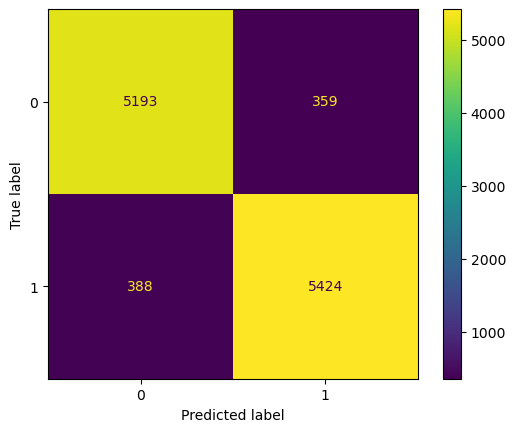

In [45]:
lr_classifier = make_pipeline(TfidfVectorizer(ngram_range=(2,2)), LogisticRegression(C=10,random_state=42, solver='newton-cg', max_iter=10000))
lr_classifier.fit(X_train.values, y_train)
evaluate_model(lr_classifier, X_test, y_test)

# XGBF

F1 score:  0.9089046358746692


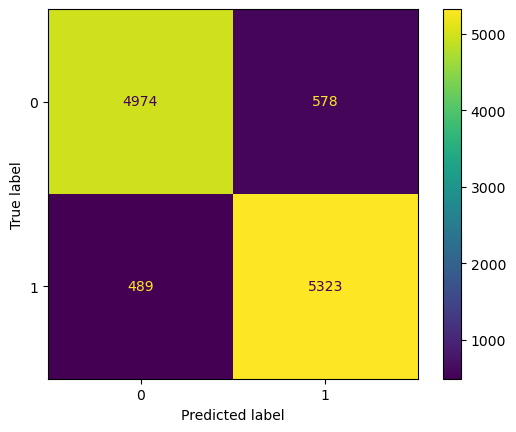

In [52]:
xgb_classifier = make_pipeline(TfidfVectorizer(max_features=10000), 
xgb.XGBClassifier(max_depth=6, n_estimators=2000, colsample_bytree=0.7, reg_alpha=0.01, reg_lambda=0.1))

xgb_classifier.fit(X_train.values, y_train)
evaluate_model(xgb_classifier, X_test, y_test)

# FeedForward Neural Network

In [21]:
class MultiLayerPerceptron2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron2, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim) # Layer
        self.relu1 = nn.ReLU()                      # Activation
        self.dropout1 = nn.Dropout(p=0.1)           #Dropout

        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2) # Layer
        self.relu2 = nn.ReLU()# Activation
        self.dropout2 = nn.Dropout(p=0.1)#Dropout

        self.batch1 = nn.BatchNorm1d(hidden_dim//2) #Normalisation

        self.fc5 = nn.Linear(hidden_dim//2, num_classes) # Layer
        self.sigmoid = nn.Sigmoid()# Activation

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.batch1(x)
         
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x

fnn_classifier = MultiLayerPerceptron2(100, 128, 2)
fnn_classifier.load_state_dict(torch.load("model/fnn1.pth"))

<All keys matched successfully>

In [9]:
pretrained_wv = gensim.downloader.load('glove-twitter-100')

def document_vector(doc, wv):
  words = word_tokenize(doc)
  word_vectors = np.array([wv[word] for word in words if word in wv])

  if len(word_vectors) == 0:
      return np.zeros(wv.vector_size)
  return np.mean(word_vectors, axis=0)

[==================================================] 100.0% 387.1/387.1MB downloaded


# LLM

In [33]:
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout

import tensorflow as tf

max_features = 75000
embedding_dim = 64
sequence_length = 512*2

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    def get_config(self):
        config = super().get_config()
        config["att"] = self.att
        config["ffn"] = self.ffn
        config["layernorm1"] = self.layernorm1
        config["layernorm2"] = self.layernorm2
        config["dropout1"] = self.dropout1
        config["dropout2"] = self.dropout2
        return config

inputs = Input(shape=(sequence_length,), dtype="int64")
x = Embedding(max_features, embedding_dim)(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
transformer_block = TransformerBlock(embedding_dim, 2, 32)
x = transformer_block(x, training=True)
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", name="predictions")(x)

llm_classifier = Model(inputs=inputs, outputs=predictions)

In [35]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    ngrams = (3,5),
    output_mode="int",
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True
)

llm_classifier.load_weights("model/my_model.weights.h5")
llm_classifier.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Analyse des performances

In [14]:

crash_test = """In the vast expanse of the universe, billions of stars twinkle in the darkness of space. Galaxies spiral and collide, nebulae glow with ethereal light, and black holes devour everything in their path. It is a place of wonder and mystery, where the laws of physics are pushed to their limits and the secrets of the cosmos remain elusive.
On a small blue planet orbiting an average star, life flourishes in all its diversity. From the depths of the oceans to the heights of the mountains, countless species of plants and animals thrive in a delicate balance. Humans, with their intelligence and ingenuity, have built civilizations, explored the world, and reached for the stars.
But even as humanity has made great strides in science and technology, there are still many unanswered questions about the universe. What lies beyond the edge of the observable universe? Are we alone in the cosmos, or are there other intelligent civilizations out there? And what is the ultimate fate of the universe itself?
As we ponder these questions, we are reminded of our place in the cosmos - small and insignificant, yet capable of great things. We are explorers, adventurers, seekers of knowledge and understanding. And as we gaze up at the stars, we are filled with a sense of wonder and awe at the vastness and beauty of the universe.
So let us continue to explore, to discover, to dream. For the universe is a place of infinite possibilities, and there is still so much left to learn and to explore. As long as we dare to dream and reach for the stars, the journey will never end. I will start my text again: 
In the vast expanse of the cosmos, stretching across billions of light-years, galaxies drift like islands in a sea of darkness. Stars twinkle like diamonds, nebulae glow with ethereal light, and black holes lurk in the depths of space. It is a place of unimaginable beauty and mystery, where the laws of physics are pushed to their limits and the secrets of the universe remain tantalizingly out of reach.
On a small blue planet nestled in the outskirts of a spiral galaxy, life teems in all its forms. From the towering redwoods of the ancient forests to the microscopic creatures that dwell in the depths of the oceans, the planet is a symphony of life and diversity. Humans, with their curiosity and ambition, have built civilizations, explored the farthest reaches of the globe, and ventured into the unknown depths of space.
But even as humanity has made great strides in understanding the world around them, there are still many mysteries left to unravel. What lies beyond the edge of the observable universe? Are there other intelligent beings out there, gazing up at the same stars and wondering about their place in the cosmos? And what is the ultimate fate of the universe itself?
As we ponder these questions, we are reminded of our own insignificance in the grand scheme of things. We are but a speck of dust in the vastness of the cosmos, a fleeting moment in the endless march of time. And yet, in our brief existence, we have achieved so much - we have explored the farthest reaches of space, unlocked the secrets of the atom, and harnessed the power of the stars themselves.
So let us continue to dream, to explore, to reach for the stars. For the universe is a place of infinite possibilities, and there is still so much left to discover. As long as there are questions left unanswered and mysteries left unsolved, the journey will never truly be over. And so we gaze up at the night sky, filled with wonder and awe at the beauty and majesty of the cosmos, and we dream of what lies beyond.
"""

tokens = crash_test.split()
print("Nombre de tokens:", len(tokens))

Nombre de tokens: 636


In [54]:
def lr_classifier_execution_time():
    start_time = time.time()
    lr_classifier.predict([crash_test])
    print("Regression Logistique temps d'exécution:", time.time() - start_time, "secondes")

def fnn_classifier_execution_time():
    start_time = time.time()
    doc_vector = document_vector(crash_test, pretrained_wv)
    doc_vector = torch.tensor(doc_vector, dtype=torch.float32).unsqueeze(0)  

    with torch.no_grad():
        fnn_classifier.eval()
        output = fnn_classifier(doc_vector)
    
    probabilities = F.softmax(output, dim=1) 
    print("FNN temps d'exécution:", time.time() - start_time, "secondes")


def xgb_classifier_execution_time():
    start_time = time.time()
    xgb_classifier.predict([crash_test])
    print("XGBoost temps d'exécution:", time.time() - start_time, "secondes")

def llm_classifier_execution_time():
    start_time = time.time()
    vectorize_layer.adapt(crash_test)
    new_answer_vectorized = vectorize_layer([crash_test]).numpy()
    prediction = model.predict(new_answer_vectorized)
    print("LLM temps d'exécution:", time.time() - start_time, "secondes")

In [55]:
lr_classifier_execution_time()
xgb_classifier_execution_time()
fnn_classifier_execution_time()
llm_classifier_execution_time()

Regression Logistique temps d'exécution: 0.028385400772094727 secondes
XGBoost temps d'exécution: 0.006531953811645508 secondes
FNN temps d'exécution: 0.007961511611938477 secondes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
LLM temps d'exécution: 0.18891024589538574 secondes
